In [8]:
import torch
import torchvision
from torchvision import transforms, models, datasets
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import CelebA
from torch.utils.data import Subset
import copy

In [70]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # 2 atrybuty do przewidywania
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Funkcja straty i optymalizator
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=1b35f9c45968dc8f1410874f129ddac47a1da27cc8cdf7299c5696fdb0d9b8d5
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [11]:
import wget
import zipfile
import os
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [12]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ścieżka do danych CelebA
celeba_path = "e:\\data\\"

test_dataset = datasets.CelebA(root=data_root,
                              split='test',
                                target_type=['attr'] ,
                               transform=transform,
                              download=True)

train_dataset = datasets.CelebA(root=data_root,
                              split='train',
                                target_type=['attr'] ,
                               transform=transform,
                              download=True)
eyeglasses_index = 15

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
glasses_labels = train_dataset.attr[:, train_dataset.attr_names.index("Eyeglasses")]

# Count the number of people with and without glasses
num_with_glasses = (glasses_labels == 1).sum().item()
num_without_glasses = (glasses_labels == 0).sum().item()


Files already downloaded and verified
Files already downloaded and verified


In [71]:
model.load_state_dict(torch.load(r'/content/model_attributes.pth', map_location=torch.device('cpu')))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# CelebA

Test Accuracy: 99.69%


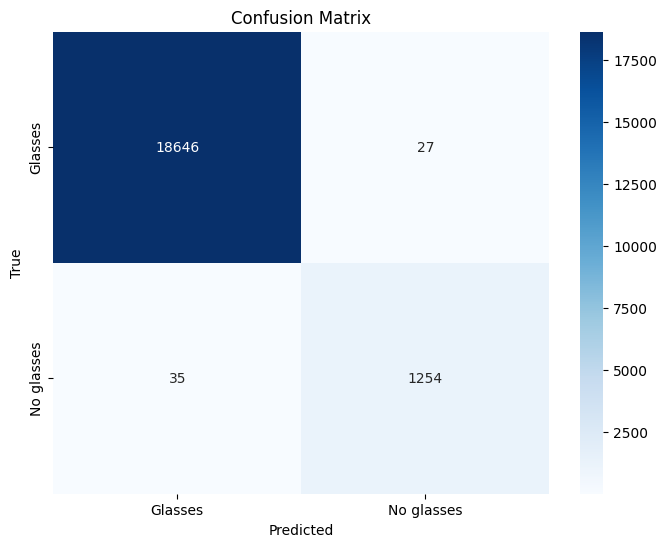

In [32]:
import seaborn as sns
import torchmetrics
import matplotlib.pyplot as plt

def get_binary_labels(labels, indices):
    binary_labels = labels[:, indices]
    return binary_labels.float()  # Konwersja na float dla BCEWithLogitsLoss


accuracy = torchmetrics.Accuracy(task='binary')
matrix = torchmetrics.ConfusionMatrix(task = 'binary')
y_pred = []
y_true = []
model.eval()
val_loss = 0
threshold = 0.5
transform = transforms.Compose([
    transforms.Resize(64,1),
    transforms.ToTensor(),
])

with torch.no_grad():
  for data, target in test_loader:
      target = get_binary_labels(target, [15])
      data, target = data.to(device), target.to(device)
      outputs = model(data)
      outputs = torch.sigmoid(outputs)
      y_true.extend((target >= threshold).int().cpu().numpy())
      y_pred.extend((outputs >= threshold).int().cpu().numpy())



y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

accuracy_value = accuracy(y_pred_tensor, y_true_tensor)
print(f"Test Accuracy: {accuracy_value * 100:.2f}%")
cm = matrix(y_pred_tensor, y_true_tensor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Glasses', 'No glasses'], yticklabels=['Glasses', 'No glasses'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('conf_matrix_glasses.png', bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def get_img():
    idx = np.random.randint(0, len(test_dataset))  # Losowy indeks w batchu
    img = test_dataset[idx][0]
    label = test_dataset[idx][1]

    index = 15
    real = get_gender(label[index])
    model.eval()
    with torch.no_grad():
        im = img.to(device).unsqueeze(0)
        output = model(im)
        pred = output

    pred = pred.cpu().numpy().flatten()
    pred = get_gender(pred[0])
    return img, real, pred


def get_gender(inn):
    pred = None
    if inn > 0.5:
        pred = "Glassess"
    else:
        pred = "No glassess"
    return pred

def pic(img, real_eyeglasses, pred_eyeglasses):
  plt.figure(figsize=(4, 4))
  img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Real eyeglasses: {real_eyeglasses}\n Predicted eyeglasses: {pred_eyeglasses}")
  plt.show()

gender = 0
figure = plt.figure(figsize=(8, 8))

img, real, pred = get_img()
pic(img, real, pred)
while (real == pred):
  img, real, pred = get_img()
pic(img, real, pred)
plt.show()





# WIDERFace

In [16]:
import zipfile
import os

data_root = "datasets"

dataset_folder = f"{data_root}/widerface"
os.makedirs(dataset_folder, exist_ok=True)

with zipfile.ZipFile(f"/content/widerface.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

In [74]:
import torchvision
import torch
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from PIL import Image
import os
from posixpath import abspath, expanduser
import numpy as np
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

class WIDERFaceTest(torchvision.datasets.WIDERFace):


    def __init__(self, root: str, split: str = "train", transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False, face_transform:Optional[Callable] = None ) -> None:
       self.face_transform = face_transform

       super().__init__(root, split, transform, target_transform, download)


    def parse_train_val_annotations_file(self) -> None:
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split, "images", line)
                    # img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)
                        faces = []
                        for i in range(len(labels)):
                          img = Image.open(img_path)
                          x = labels[i][0] - (labels[i][2] / 5)
                          y = labels[i][1] - (labels[i][3] / 5)
                          w = labels[i][2] + (labels[i][2] / 5)
                          h = labels[i][3] + (labels[i][3] / 5)
                          box = [x,y,x+w,y+h]
                          img = img.crop(box)
                          img = self.face_transform(img)
                          faces.append(img)
                        self.img_info.append(
                            {
                                "img_path": img_path,
                                "annotations": {
                                    "bbox": labels_tensor[:, 0:4].clone(),  # x, y, width, height
                                    "gender" : labels_tensor[:, 10].clone(),
                                    "glasses" : labels_tensor[:, 11].clone(),
                                    'faces': faces.copy(),

                                },
                            }
                        )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(f"Error parsing annotation file {filepath}")

        def __getitem__(self, index: int):
          target = None if self.split == "test" else self.img_info[index]["annotations"]
          if self.target_transform is not None:
              target = self.target_transform(target)
          return self.img_info[index]["faces"], target

class WIDERFaceDataset(torch.utils.data.Dataset):
    def __init__(self, widerface_dataset):
        self.widerface_dataset = widerface_dataset

    def __getitem__(self, index):
        faces, target = self.widerface_dataset[index]
        return target['faces'], target['gender']

    def __len__(self):
        return len(self.widerface_dataset)




In [7]:


imagenet_data =  torchvision.datasets.WIDERFace(f'datasets', download=True, split='train')


Using downloaded and verified file: datasets/widerface/WIDER_train.zip
Using downloaded and verified file: datasets/widerface/WIDER_val.zip


1844140520it [00:17, 103152382.76it/s]


100%|██████████| 3591642/3591642 [00:00<00:00, 7337135.77it/s]


Extracting datasets/widerface/wider_face_split.zip to datasets/widerface


In [75]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
imagenet_data =  WIDERFaceTest('/content/datasets', download=False, split='train', face_transform=transform)
widerface_loader = DataLoader(WIDERFaceDataset(imagenet_data), batch_size=1, shuffle=True, num_workers=1 )


In [24]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.6 MB/s eta 0:00:00


Test Accuracy: 50.92%


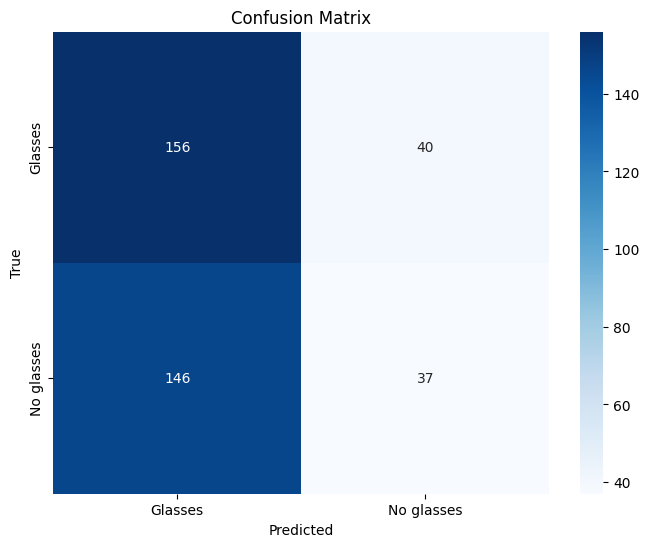

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

import torchmetrics
accuracy = torchmetrics.Accuracy(task='binary')
matrix = torchmetrics.ConfusionMatrix(task = 'binary')
y_pred = []
y_true = []
model.eval()
val_loss = 0
threshold = 0.5


with torch.no_grad():
  for data, target in widerface_loader:
      target = target[0]
      outputs = []
      for i in range(len(target)):
        if target[i] == 1:
          real = torch.tensor([[0]])
        else:
          real = torch.tensor([[1]])
        inn, label = data[i].to(device), real.to(device)
        output = model(inn)
        y_pred.extend((output >= threshold).int().cpu().numpy())
        y_true.extend((real >= threshold).int().cpu().numpy())


y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

accuracy_value = accuracy(y_pred_tensor, y_true_tensor)
print(f"Test Accuracy: {accuracy_value * 100:.2f}%")
cm = matrix(y_pred_tensor, y_true_tensor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Glasses', 'No glasses'], yticklabels=['Glasses', 'No glasses'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def get_img(test_dataset):
    idx = np.random.randint(0, len(test_dataset))  # Losowy indeks w batchu
    img = test_dataset[idx][1]['faces']
    label = test_dataset[idx][1]['glasses']
    outputs= []
    real = []
    model.eval()
    with torch.no_grad():
      for i in range(len(img)):
        im = img[i].to(device).unsqueeze(0)
        output = model(im)
        pred = output
        outputs.extend(pred)

    real = get_gender(label)
    pred = get_gender(outputs)
    return img, real, pred, test_dataset[idx][0]


def get_gender(pred):
    pred_g = ""
    out = []
    for i in pred:
      if i > 0.5:
          pred_g = "Glasses"
      else:
          pred_g = "No glasses"
      out.append(pred_g)
    return out

def pic(img, real_eyeglasses, pred_eyeglasses):
  plt.figure(figsize=(4, 4))
  # img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Real eyeglasses: {real_eyeglasses}\n Predicted eyeglasses: {pred_eyeglasses}")
  plt.show()


# Wyświetlanie obrazu z predykcjami i etykietami rzeczywistymi
gender = 0
figure = plt.figure(figsize=(4, 8))
cols, rows = 1, 2
img, real, pred, full = get_img(imagenet_data)
pic(full, real, pred)
